# Support Vector Machines (SVMs)

Code by Michael Shaham, a PhD student at Northeastern University, supplemented with notes by Mark Zolotas.

In [1]:
import copy
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(7)

Note that [cvxpy](https://www.cvxpy.org/) is an open-source Python modelling framework that provides access to many different convex optimization problem solvers. It provides a mathematically intuitive and effective way of expressing your problem in Python for the solver. 

We will not dive deeper into this framework for the course, however if you are interested in convex optimization, here are further references:

- https://web.stanford.edu/~boyd/cvxbook/
- https://web.stanford.edu/class/ee364a/

## Least Squares Classification

Line 1:  
$$x_2 = 2x_1 \implies x_1 - x_2 = 0 \implies \mathbf{w}_1^\intercal \mathbf{x} = b_1,\ \mathbf{w}_1 = [2, -1],\ b_1 = 0.$$

Line 2:  
$$x_2 = 2x_1 - 8 \implies x_1 - x_2 = 8 \implies \mathbf{w}_2^\intercal \mathbf{x} = b_2,\ \mathbf{w}_2 = [2, -1],\ b_2 = 8.$$

Ideal separator:  
$$\mathbf{w}^\intercal \mathbf{x} = b,\ \mathbf{w} = [2, -1],\ b = 4.$$

Least squares classification loss objective:

\begin{align*}
L_\text{ls}(\mathbf{w}) & = ||\mathbf{y} - \mathbf{X}\mathbf{w}||_2^2 \\
& = \sum_{i=1}^N (1 - y^{(i)}\mathbf{w}^\intercal \mathbf{x}^{(i)})^2.
\end{align*}

### Dataset

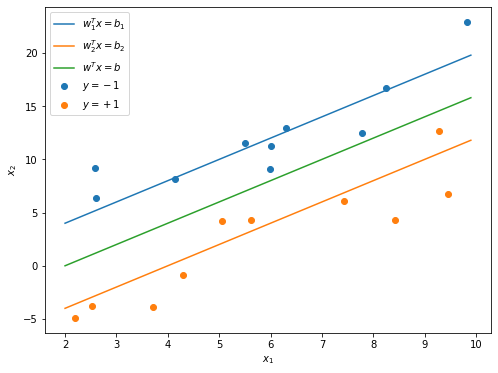

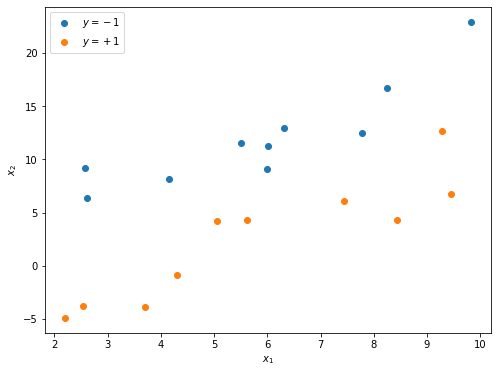

In [2]:
# we'll generate data from the two lines given above

x_1_range = np.arange(2, 10, .1)
x_2_l1 = 2*x_1_range
x_2_l2 = 2*x_1_range - 8
x_2_sep = 2*x_1_range - 4

plt.figure(figsize=(8, 6))
plt.plot(x_1_range, x_2_l1, label=r"$w_1^Tx = b_1$")
plt.plot(x_1_range, x_2_l2, label=r"$w_2^Tx = b_2$")
plt.plot(x_1_range, x_2_sep, label=r"$w^Tx = b$")

# generate some data points from each line with noise

N_1 = 10
N_2 = 10
N = N_1 +N_2
# first m_1 data points belong to line 1 (y = -1), rest to line 2 (y = +1)
x_1_data = 2 + 8*np.random.rand(N)
x_2_data = np.r_[2*x_1_data[:N_1] + 2*np.random.randn(N_1), 
                 2*x_1_data[N_1:] - 8 + 2*np.random.randn(N_2)]
y_data = np.r_[-1*np.ones(N_1), np.ones(N_2)]

plt.scatter(x_1_data[:N_1], x_2_data[:N_1], label=r"$y=-1$")
plt.scatter(x_1_data[N_1:], x_2_data[N_1:], label=r"$y=+1$")
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.show();

plt.figure(figsize=(8, 6))
plt.scatter(x_1_data[:N_1], x_2_data[:N_1], label=r"$y=-1$")
plt.scatter(x_1_data[N_1:], x_2_data[N_1:], label=r"$y=+1$")
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
# plt.savefig("figures/svm_raw_2d_data.png", bbox_inches='tight')
plt.show();

### Case 1: No Outliers

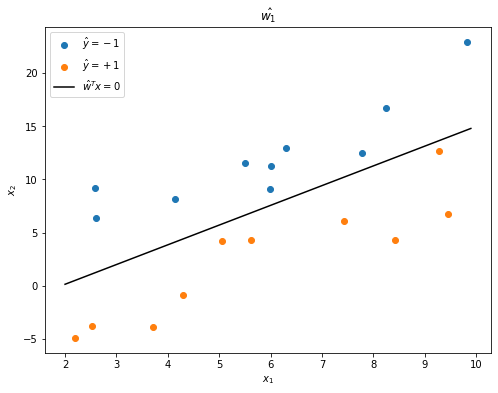

In [3]:
# create data matrices/vectors
X = np.c_[x_1_data, x_2_data, np.ones(N)]
y = copy.deepcopy(y_data)

# find least squares classifier
w_no_out = np.linalg.inv(X.T @ X) @ X.T @ y

# make predictions:
y_hat = np.sign(X @ w_no_out)
l1_inds = y_hat == -1
l2_inds = y_hat == 1

plt.figure(figsize=(8, 6))

# plot data and predictions
plt.scatter(X[l1_inds, 0], X[l1_inds, 1], label=r"$\hat{y} = -1$")
plt.scatter(X[l2_inds, 0], X[l2_inds, 1], label=r"$\hat{y} = +1$")

# plot optimal decision boundary
w_1, w_2, w_0 = w_no_out
x_1_opt = copy.deepcopy(x_1_range)
x_2_no_out = (-w_0 - w_1*x_1_opt) / w_2
plt.plot(x_1_opt, x_2_no_out, 'k-', label=r"$\hat{w}^T x = 0$")

plt.title(r"$\hat{w_1}} = (%.2f, %.2f),\ \hat{w_0} = %.2f$" % (w_1, w_2, w_0))
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# plt.savefig("figures/svm_2d_opt_no_outliers.png", bbox_inches='tight')
plt.show();

The closed-form least squares solution $\hat{\mathbf{w}} = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^\intercal \mathbf{y}$ finds a reasonable decision boundary in this case, where the data is assumed to be linearly separable and have no outliers.

### Case 2: Outliers

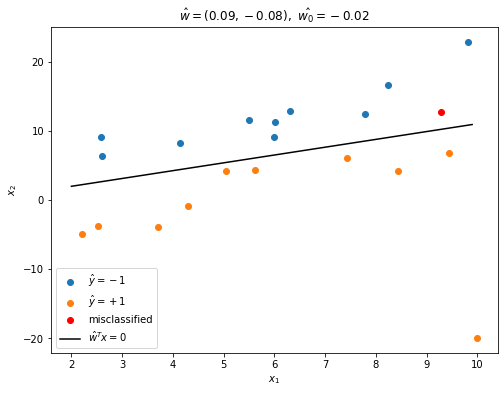

In [4]:
# add an outlier data point to data with label +1
X_out = np.r_[X, np.array([[10, -20, 1]])]
y = np.r_[y, 1]
N = len(y)

plt.figure(figsize=(8, 6))

# find least squares classifier
w_out = np.linalg.inv(X_out.T @ X_out) @ X_out.T @ y

# make predictions:
y_hat = np.sign(X_out @ w_out)
correct_inds = y_hat == y
incorrect_inds = correct_inds == False
l1_preds = y_hat == -1
l2_preds = y_hat == 1

# plot data and predictions
plt.scatter(X_out[correct_inds, 0][:N_1], X_out[correct_inds, 1][:N_1], label=r"$\hat{y} = -1$")
plt.scatter(X_out[correct_inds, 0][N_1:], X_out[correct_inds, 1][N_1:], label=r"$\hat{y} = +1$")
plt.scatter(X_out[incorrect_inds, 0], X_out[incorrect_inds, 1], c='red', label="misclassified")

# plot optimal decision boundary
w_1, w_2, w_0 = w_out
x_1_opt = copy.deepcopy(x_1_range)
x_2_out = (-w_0 - w_1*x_1_opt) / w_2
plt.plot(x_1_opt, x_2_out, 'k-', label=r"$\hat{w}^T x = 0$")

plt.title(r"$\hat{w} = (%.2f, %.2f),\ \hat{w_0} = %.2f$" % (w_1, w_2, w_0))
plt.legend(loc="lower left")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# plt.savefig("figures/svm_2d_opt_outliers.png", bbox_inches='tight')
plt.show();

However here, we see that the least squares solution is very sensitive to the presence of outliers because you square the residual error and penalize samples far away from the decision boundary, which is actually a desirable trait. Even though the classes are still perfectly separable, a misclassification has now occurred (red point), illustrating the weakness of this classifier.

### Quick Aside: $l_1$ vs $l_2$ vs $l_\infty$ Regression

Quick aside to illustrate the effects of using different $l_p$ norms for the least squares regression objective, namely the cases where $p = 1, 2, \infty$. You can skim over this part of the code and if you're curious about more details then I recommend reading the starred 11.6 chapter on <i>robust linear regression</i> from Murphy's 2022 book.

In [5]:
# solve l2 problem

N = X_out.shape[0]
n = X_out.shape[1]

# solved for least squares problem above already
w_l2 = w_out

In [6]:
# solve l1 problem (sum of absolute residuals approximation or robust estimation)

# show equivalence of the two problems
w_1 = cp.Variable(n)
loss_1 = cp.norm1(X_out @ w_1 - y)
prob_1 = cp.Problem(cp.Minimize(loss_1))
prob_1.solve()
w_1 = w_1.value

w_2 = cp.Variable(n)
t = cp.Variable(N)
loss_2 = cp.sum(t)
constraints = [X_out @ w_2 - y <= t,
               X_out @ w_2 - y >= -t]
prob_2 = cp.Problem(cp.Minimize(loss_2), constraints)
prob_2.solve()
w_2 = w_2.value

print((w_1 == w_2).all())
w_l1 = w_1

True


In [7]:
# solve l_inf problem (Chebyshev/minimax)

# show equivalence of the two problems
w_1 = cp.Variable(n)
loss_1 = cp.norm(X_out @ w_1 - y, p='inf')
prob_1 = cp.Problem(cp.Minimize(loss_1))
prob_1.solve()
w_1 = w_1.value

w_2 = cp.Variable(n)
t = cp.Variable()
loss_2 = t
constraints = [X_out @ w_2 - y <= t * np.ones(N),
               X_out @ w_2 - y >= -t * np.ones(N)]
prob_2 = cp.Problem(cp.Minimize(loss_2), constraints)
prob_2.solve()
w_2 = w_2.value

print((w_1 == w_2).all())
w_l_inf = w_1

True


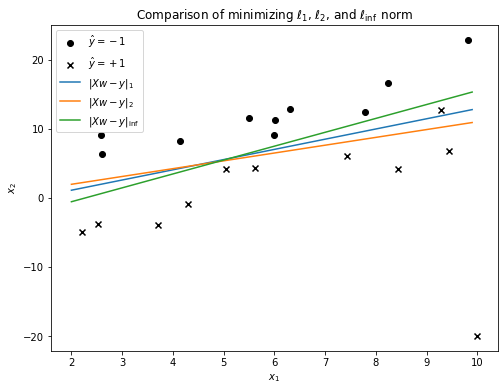

In [8]:
plt.figure(figsize=(8, 6))

plt.scatter(X_out[:N_1, 0], X_out[:N_1, 1], c='black', marker='o', label=r"$\hat{y} = -1$")
plt.scatter(X_out[N_1:, 0], X_out[N_1:, 1], c='black', marker='x', label=r"$\hat{y} = +1$")

# plot optimal decision boundary
w_vals = [w_l1, w_l2, w_l_inf]
norms = ["1", "2", "\inf"]
for w, n in zip(w_vals, norms):
    w_1, w_2, w_0 = w
    x_2_vals = (-w_0 - w_1*x_1_range) / w_2
    plt.plot(x_1_range, x_2_vals, label=r"$\|X w - y\|_{}$".format(n))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r"Comparison of minimizing $\ell_1$, $\ell_2$, and $\ell_\inf$ norm")
plt.legend()
plt.show();

## Hinge Loss Minimization

The hinge loss objective function is:

$$L_\text{hinge}(\mathbf{w}) = \sum_{i=1}^N (1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)})_+,$$

where $z_+ = \text{max}(0, z)$ and the minimization problem is:

$$\min_\mathbf{w} L_\text{hinge}(\mathbf{w}) = \min_\mathbf{w} \sum_{i=1}^N (1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)})_+.$$

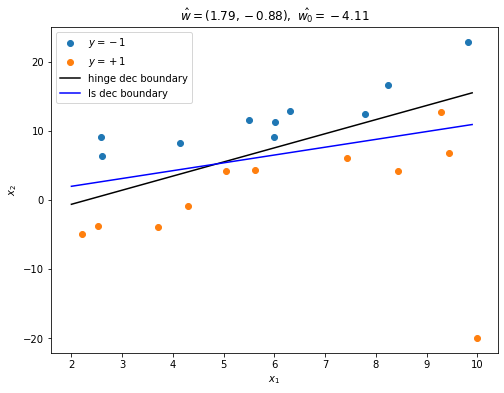

In [9]:
# set up cvx opt problem
n = X_out.shape[1]
w_hinge = cp.Variable((n, 1))
# cp.pos is same as the + notation, i.e. max(0, z) for whatever z is passed to f(z)
loss = cp.sum(cp.pos(1 - cp.multiply(y, (X_out @ w_hinge).flatten())))
# Format for a minimization problem
prob = cp.Problem(cp.Minimize(loss))
prob.solve()

w_1, w_2, w_0 = w_hinge.value
x_2_hinge = (-w_0 - w_1*x_1_range) / w_2

plt.figure(figsize=(8, 6))
plt.scatter(X_out[:N_1, 0], X_out[:N_1, 1], label=r"$y=-1$")
plt.scatter(X_out[N_1:, 0], X_out[N_1:, 1], label=r"$y=+1$")
plt.plot(x_1_range, x_2_hinge, 'k-', label="hinge dec boundary")
plt.plot(x_1_opt, x_2_out, 'b-', label="ls dec boundary")

plt.title(r"$\hat{w} = (%.2f, %.2f),\ \hat{w_0} = %.2f$" % (w_1, w_2, w_0))
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# plt.savefig("figures/svm_2d_hinge_comp.png", bbox_inches='tight')
plt.show();

This is a far better approximation to misclassification error $L_\text{nerr}$:

$$L_\text{nerr}(\mathbf{w}) = \frac{1}{2}\sum_{i=1}^N (1 - \text{sgn}(y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)})),$$

and is no longer penalizing points that are correctly classified but located far away from the decision boundary.

## Maximum Margin Classification

The maximum margin objective can be expressed as the following minimization problem:

\begin{align}
\min_\mathbf{w} \quad & ||\mathbf{w}||^2 \\ \text{subject to} \quad & 1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)} \geq 0, \forall i,
\end{align}

which is also known as the <b>hard-margin</b> formulation of a linear SVM.

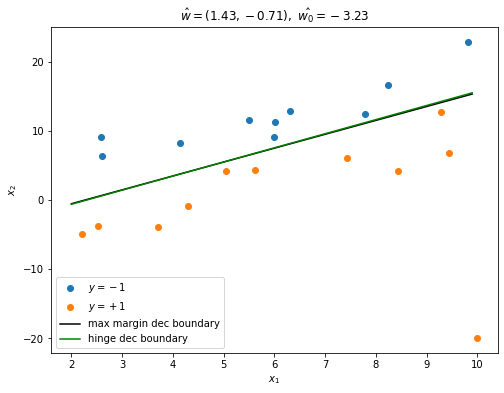

In [10]:
# set up cvx opt problem
w_mm = cp.Variable((n, 1))
loss = cp.norm2(w_mm[:2])**2
constraints = [1 - cp.multiply(y, (X_out @ w_mm).flatten()) <= 0]
prob = cp.Problem(cp.Minimize(loss), constraints)
prob.solve()

w_1, w_2, w_0 = w_mm.value
x_2_mm = (-w_0 - w_1*x_1_range) / w_2

plt.figure(figsize=(8, 6))
plt.scatter(X_out[:N_1, 0], X_out[:N_1, 1], label=r"$y=-1$")
plt.scatter(X_out[N_1:, 0], X_out[N_1:, 1], label=r"$y=+1$")
plt.plot(x_1_range, x_2_mm, 'k-', label="max margin dec boundary")
plt.plot(x_1_range, x_2_hinge, 'g-', label="hinge dec boundary")
# plt.plot(x_1_opt, x_2_out, 'b-', label="ls dec boundary")

plt.title(r"$\hat{w} = (%.2f, %.2f),\ \hat{w_0} = %.2f$" % (w_1, w_2, w_0))
plt.legend(loc='lower left')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# plt.savefig("figures/svm_2d_max_margin.png", bbox_inches='tight')
plt.show();

However, if the data is NOT linearly separable, then the constraint $(1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)}) \geq 0$ is infeasible for all $N$ samples. To combat this, we introduce [slack variables](https://en.wikipedia.org/wiki/Slack_variable#:~:text=In%20an%20optimization%20problem%2C%20a,constraint%20on%20the%20slack%20variable.) next and present the SVM as a <b>soft-margin</b> classifier.

## SVMs

The SVM is finally provided as a model capable of handling classification on a dataset that is not perfectly separable, i.e. it contains overlapping class-conditional distributions. As there is no feasible solution in this case to satisfy the constraint $(1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)}) \geq 0$ for all $N$, we replace these hard constraints with "softer" margin constraints by introducing slack variables $\epsilon^{(i)}$:

\begin{align}
\min_{\mathbf{w}, \epsilon} \quad & ||\mathbf{w}||^2 + \lambda \sum_{i=1}^N \epsilon^{(i)} \\
\text{subject to} \quad & \epsilon^{(i)} \geq 1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)}, \forall i \\
& \epsilon^{(i)} \geq 0,
\end{align}

which can be equivalently written as:

$$\min_\mathbf{w} ||\mathbf{w}||^2 + \lambda \sum_{i=1}^N (1 - y^{(i)}\mathbf{w}^\intercal\mathbf{x}^{(i)})_+.$$

SVMs thus derive an optimal $\mathbf{w}$ that trades-off between number of misclassifications and the width of the slab (size of the margin), with a regularization parameter $\lambda$ to control this trade-off.

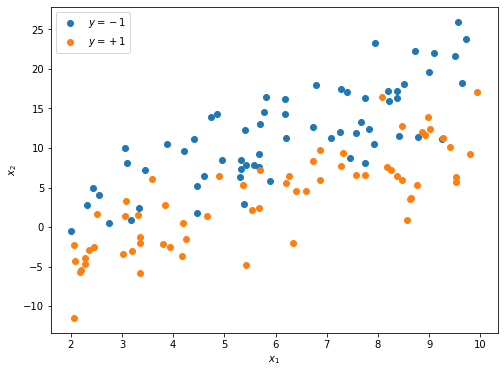

In [11]:
# generate overlapping data

x_1_range = np.arange(2, 10, .1)
x_2_l1 = 2*x_1_range
x_2_l2 = 2*x_1_range - 8

# generate some data points from each line with noise

N_1 = 64
N_2 = 64
N = N_1 + N_2
# first m_1 data points belong to line 1 (y = -1), rest to line 2 (y = +1)
x_1_data = 2 + 8*np.random.rand(N)
noise = 4
x_2_data = np.r_[2*x_1_data[:N_1] + noise*np.random.randn(N_1), 
                 2*x_1_data[N_1:] - 8 + noise*np.random.randn(N_2)]
X = np.c_[x_1_data, x_2_data, np.ones_like(x_1_data)]
y = np.r_[-1*np.ones(N_1), np.ones(N_2)]

plt.figure(figsize=(8, 6))
plt.scatter(x_1_data[:N_1], x_2_data[:N_1], label=r"$y=-1$")
plt.scatter(x_1_data[N_1:], x_2_data[N_1:], label=r"$y=+1$")
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# plt.savefig("figures/svm_2d_overlap_toy_data.png", bbox_inches='tight')
plt.show();

[[ 0.02202114]
 [-0.10604029]
 [ 0.6410145 ]]
lambda = 0.001, number correct = 101
lambda = 100, number correct = 105


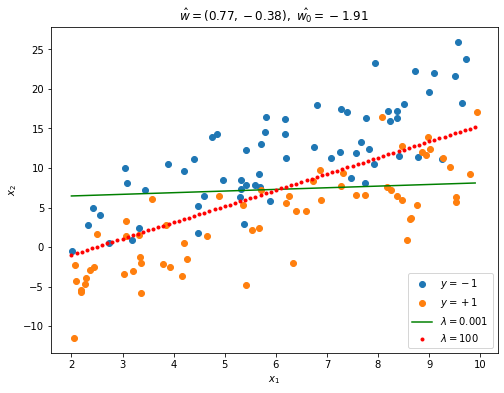

In [13]:
# solve using slack variable formulation

lam_1 = 1e-3
w_svm1 = cp.Variable((n, 1))
eps1 = cp.Variable((N, 1))
loss1 = cp.norm2(w_svm1[:2])**2 + \
        lam_1*cp.sum(eps1)
constraints_1 = [1 - cp.vec(eps1) <= cp.multiply(y, (X @ w_svm1).flatten()),
                eps1 >= 0]
prob_1 = cp.Problem(cp.Minimize(loss1), constraints_1)
prob_1.solve()

print(w_svm1.value)
w_1, w_2, w_0 = w_svm1.value
x_2_svm1 = (-w_0 - w_1*x_1_range) / w_2

# solve using the hinge loss formulation

lam_2 = 100

w_svm2 = cp.Variable((n, 1))
loss2 = cp.norm2(w_svm2[:2])**2 + \
        lam_2*cp.sum(cp.pos(1 - cp.multiply(y, (X @ w_svm2).flatten())))
prob_2 = cp.Problem(cp.Minimize(loss2))
prob_2.solve()

w_1, w_2, w_0 = w_svm2.value
x_2_svm2 = (-w_0 - w_1*x_1_range) / w_2

y_hat_1 = np.sign(X @ w_svm1.value).flatten()
correct_1 = np.count_nonzero(np.int64(y_hat_1 == y))
print("lambda = {}, number correct = {}".format(lam_1, correct_1))

y_hat_2 = np.sign(X @ w_svm2.value).flatten()
correct_2 = np.count_nonzero(np.int64(y_hat_2 == y))
print("lambda = {}, number correct = {}".format(lam_2, correct_2))

plt.figure(figsize=(8, 6))
plt.scatter(X[:N_1, 0], X[:N_1, 1], label=r"$y=-1$")
plt.scatter(X[N_1:, 0], X[N_1:, 1], label=r"$y=+1$")
plt.plot(x_1_range, x_2_svm1, 'g-', label=r"$\lambda={}$".format(lam_1))
plt.plot(x_1_range, x_2_svm2, 'r.', label=r"$\lambda={}$".format(lam_2))

plt.title(r"$\hat{w} = (%.2f, %.2f),\ \hat{w_0} = %.2f$" % (w_1, w_2, w_0))
plt.legend(loc='lower right')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

# plt.savefig("figures/svm_2d_overlap.png", bbox_inches='tight')
plt.show();

This example shows how with an appropriately set $\lambda$ value, e.g. $10$, a suitable decision hyperplane can be derived despite the overlapping data.